In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Load in the data

In [19]:
streamflow_data = pd.read_csv("data/streamflow_data/Final_Processed_Station_Data_Watershed.csv")
streamflow_data.dropna(inplace=True)
streamflow_data.head(5)

C:\Users\tbwil\AppData\Local\Temp\ipykernel_12704\1023125811.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241) have mixed types. Specify dtype option on import or

,name,ADAMS RIVER NEAR SQUILAX,ALOUETTE RIVER NEAR HANEY,ANDERSON CREEK NEAR NELSON,ANSEDAGAN CREEK NEAR NEW AIYANSH,ARROW CREEK NEAR ERICKSON,ASH RIVER BELOW MORAN CREEK,ASHNOLA RIVER NEAR KEREMEOS,ATNARKO RIVER NEAR THE MOUTH,BABINE RIVER AT OUTLET OF NILKITKWA LAKE,...,VANCE CREEK BELOW DEAFIES CREEK,VASEUX CREEK ABOVE SOLCO CREEK,VERNON CREEK AT OUTLET OF KALAMALKA LAKE,WANNOCK RIVER AT OUTLET OF OWIKENO LAKE,WEST CREEK NEAR FORT LANGLEY,WEST KETTLE RIVER AT WESTBRIDGE,WEST KETTLE RIVER NEAR MCCULLOCH,WHITEMAN CREEK ABOVE BOULEAU CREEK,YALAKOM RIVER ABOVE ORE CREEK,ZEBALLOS RIVER AT MOOK PEAK
0,lat,50.93759,49.239,49.50195,55.12986,49.15912,49.36992,49.20763,52.36008,55.42654,...,50.28432,49.24928,50.23847,51.67917,49.14767,49.16981,49.70292,50.21222,50.91261,50.13569
1,lon,-119.65634,-122.57975,-117.26128,-129.35494,-116.45249,-124.98411,-119.99352,-126.00586,-126.69763,...,-118.94704,-119.32139,-119.26689,-127.17917,-122.53187,-118.97506,-119.09247,-119.53861,-122.23931,-126.82006
2,major_watershed,South Thompson River,Fraser River,Lower Kootenay River,Nass River,Lower Kootenay River,Vancouver Island (West) Rivers,Okanagan River,North Coast Rivers,Babine River,...,South Thompson River,Okanagan River,Okanagan River,North Coast Rivers,Fraser River,Kettle River,Kettle River,Okanagan River,Fraser River,Vancouver Island (West) Rivers
3,2011-01-01,21.10065052,3.950658369,0.026633333,0.175258698,0.49568895,12.29111538,1.690907985,-126.00586,15.4966629,...,0.067015878,0.083,0.075272787,99.95522759,0.072746181,1.596026005,0.401,0.04718573,1.238667116,0.176193638
4,2011-01-02,20.69611806,3.74086273,0.0249375,0.163091831,0.485078758,11.49209615,1.755803793,-120.3616256,15.25197908,...,0.067070577,0.081,0.07749122,94.00841842,0.052530297,1.552300933,0.392296896,0.047,1.195453978,0.147495593


In [20]:
station_lats = streamflow_data.iloc[0][1:]
station_lons = streamflow_data.iloc[1][1:]
watersheds = streamflow_data.iloc[2][1:]

# drop the first 3 rows
streamflow_data = streamflow_data.drop([0, 1, 2])
# drop the first column
streamflow_data = streamflow_data.drop(columns=["name"])
streamflow_data = streamflow_data.astype(float)
streamflow_data.head(5)

,ADAMS RIVER NEAR SQUILAX,ALOUETTE RIVER NEAR HANEY,ANDERSON CREEK NEAR NELSON,ANSEDAGAN CREEK NEAR NEW AIYANSH,ARROW CREEK NEAR ERICKSON,ASH RIVER BELOW MORAN CREEK,ASHNOLA RIVER NEAR KEREMEOS,ATNARKO RIVER NEAR THE MOUTH,BABINE RIVER AT OUTLET OF NILKITKWA LAKE,BAKER CREEK AT QUESNEL,...,VANCE CREEK BELOW DEAFIES CREEK,VASEUX CREEK ABOVE SOLCO CREEK,VERNON CREEK AT OUTLET OF KALAMALKA LAKE,WANNOCK RIVER AT OUTLET OF OWIKENO LAKE,WEST CREEK NEAR FORT LANGLEY,WEST KETTLE RIVER AT WESTBRIDGE,WEST KETTLE RIVER NEAR MCCULLOCH,WHITEMAN CREEK ABOVE BOULEAU CREEK,YALAKOM RIVER ABOVE ORE CREEK,ZEBALLOS RIVER AT MOOK PEAK
3,21.100651,3.950658,0.026633,0.175259,0.495689,12.291115,1.690908,-126.005860,15.496663,0.779153,...,0.067016,0.083,0.075273,99.955228,0.072746,1.596026,0.401000,0.047186,1.238667,0.176194
4,20.696118,3.740863,0.024938,0.163092,0.485079,11.492096,1.755804,-120.361626,15.251979,0.777872,...,0.067071,0.081,0.077491,94.008418,0.052530,1.552301,0.392297,0.047000,1.195454,0.147496
5,20.412194,3.620703,0.023571,0.166408,0.486131,10.892279,1.819793,-114.717391,15.246768,0.772798,...,0.067069,0.079,0.079711,87.546224,0.036934,1.541753,0.383060,0.061246,1.150701,0.136078
6,20.203941,3.528421,0.024729,0.178720,0.498147,10.455154,1.879251,-109.073157,15.616654,0.768037,...,0.067029,0.077,0.082849,82.198203,0.035229,1.570497,0.373180,0.066975,1.107009,0.183736
7,20.193618,5.366124,0.024850,0.188595,0.509200,11.024510,1.930552,-103.428922,16.034901,0.763594,...,0.066954,0.075,0.087453,85.333824,0.458728,1.617611,0.362546,0.063745,1.066981,2.734586


In [ ]:
# load in the precipitation and temperature data
rainfall_data = np.load("data/weather_data/rainfall_data.npy").astype(float)
snowfall_data = np.load("data/weather_data/snowfall_data.npy").astype(float)
max_temp_data = np.load("data/weather_data/max_temp_data_interp.npy").astype(float)
min_temp_data = np.load("data/weather_data/min_temp_data_interp.npy").astype(float)

# Split the data into training, validation, and test sets

In [ ]:
# define the fractions
train_frac = 7/9
val_frac = 1/9
test_frac = 1/9

assert train_frac + val_frac + test_frac == 1

# define the indices for the train, validation, and test sets
train_idx = int(train_frac * len(streamflow_data))
val_idx = int((train_frac + val_frac) * len(streamflow_data))
n_train = train_idx
n_val = val_idx - train_idx
n_test = len(streamflow_data) - val_idx

assert n_train + n_val + n_test == len(streamflow_data)

# standardize the data based on the training set
rainfall_data = (rainfall_data - np.mean(rainfall_data[:train_idx])) / np.std(rainfall_data[:train_idx])
snowfall_data = (snowfall_data - np.mean(snowfall_data[:train_idx])) / np.std(snowfall_data[:train_idx])
max_temp_data = (max_temp_data - np.mean(max_temp_data[:train_idx])) / np.std(max_temp_data[:train_idx])
min_temp_data = (min_temp_data - np.mean(min_temp_data[:train_idx])) / np.std(min_temp_data[:train_idx])
streamflow_data = (streamflow_data - streamflow_data.iloc[:train_idx].mean()) / streamflow_data.iloc[:train_idx].std()
streamflow_data = streamflow_data.to_numpy()

In [ ]:
# define the time window
time_window = 60
n_channels = 4
grid_shape = rainfall_data.shape[1:]
n_stations = streamflow_data.shape[1]

# create the training, validation, and test sets
x_intermediate = np.empty(np.shape(rainfall_data) + (n_channels,), dtype='single')
for i, data in enumerate([rainfall_data, snowfall_data, max_temp_data, min_temp_data]):
    x_intermediate[:,:,:,i] = data

def gen_train(time_window):
    for i in range(n_train - time_window):
        xx = tf.convert_to_tensor(x_intermediate[i:i+time_window])
        yy = streamflow_data[time_window + i,:]
        yield (xx, yy)

def gen_val(time_window):
    for i in range(n_val):
        xx = tf.convert_to_tensor(x_intermediate[i+n_train-time_window:i+n_train])
        yy = streamflow_data[val_idx + i,:]
        yield (xx, yy)

def gen_test(time_window):
    for i in range(n_test):
        xx = tf.convert_to_tensor(x_intermediate[i+val_idx-time_window:i+val_idx])
        yy = streamflow_data[val_idx + i,:]
        yield (xx, yy)

# Create a model

In [ ]:
def create_model():
    # Input layer
    cnn_input = layers.Input(shape=(time_window, 22, 37, n_channels), name="Weather_Data_Input")
    
    # TimeDistributed CNN
    cnn = layers.TimeDistributed(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))(cnn_input)
    cnn = layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))(cnn)
    cnn = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(cnn)
    cnn = layers.TimeDistributed(layers.Flatten())(cnn)  # Flatten the grid

    # LSTM for temporal patterns
    lstm = layers.LSTM(64, return_sequences=False, activation='tanh')(cnn)

    # Fully connected layers
    dense = layers.Dense(32, activation='relu')(lstm)
    dense = layers.Dropout(0.2)(dense)  # Dropout for regularization
    output = layers.Dense(n_stations, activation='linear', name="Streamflow_Output")(dense)

    # Model definition
    model = models.Model(inputs=cnn_input, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = create_model()
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Rainfall_Input (InputLayer)     │ (None, 60, 22, 37, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_67             │ (None, 60, 22, 37, 8)  │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_68             │ (None, 60, 8)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 60, 32)         │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 241)            │         7,953 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,801 (89.07 KB)

 Trainable params: 22,801 (89.07 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# def create_model(learning_rate=0.001):
#     model = models.Sequential()
#     cnn_input = layers.Input(shape=(time_window, *grid_shape, n_channels), name="Rainfall_Input")
#     cnn = layers.TimeDistributed(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))(cnn_input)
#     cnn = layers.TimeDistributed(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))(cnn)
#     cnn = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(cnn)
#     cnn = layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))(cnn)
#     cnn = layers.TimeDistributed(layers.GlobalMaxPooling2D())(cnn)
#     cnn = layers.Dropout(0.1)(cnn)
#     cnn = layers.LSTM(30, return_sequences=True)(cnn)
#     cnn = layers.LSTM(7)(cnn)
#     cnn = layers.Dense(32, activation='relu')(cnn)
#     cnn = layers.Dense(n_stations)(cnn)
#     model = models.Model(inputs=cnn_input, outputs=cnn)
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.MSE)
#     return model

# model = create_model()
# model.summary()

In [33]:
# create datasets and train an ensemble
batch_size = 8
ensemble_size = 10
learning_rate = 0.01

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             mode='min',
                                             verbose=1,
                                             patience=5,
                                             restore_best_weights=True)

for i in range(ensemble_size):
    print(f"Training model {i+1}/{ensemble_size}")

    train_dataset = tf.data.Dataset.from_generator(
        gen_train,
        (tf.float16, tf.float16),
        (tf.TensorShape([time_window, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
    ).shuffle(n_train).batch(batch_size)

    val_dataset = tf.data.Dataset.from_generator(
        gen_val,
        (tf.float16, tf.float16),
        (tf.TensorShape([time_window, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
    ).shuffle(n_val).batch(batch_size)

    test_dataset = tf.data.Dataset.from_generator(
        gen_test,
        (tf.float16, tf.float16),
        (tf.TensorShape([time_window, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
    ).shuffle(n_test).batch(batch_size)

    model = create_model()
    model.fit(
        train_dataset,
        epochs=40,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[callbacks],
    )

    # save the model
    model.save(f"models/ensemble_model_{i}.keras")


Training model 1/10
Epoch 1/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 80s 218ms/step - loss: 0.8505 - val_loss: 0.4457
Epoch 2/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 70s 210ms/step - loss: 0.4640 - val_loss: 0.4107
Epoch 3/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 70s 212ms/step - loss: 0.4147 - val_loss: 0.4212
Epoch 4/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 70s 212ms/step - loss: 0.3934 - val_loss: 0.4284
Epoch 5/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 214ms/step - loss: 0.3902 - val_loss: 0.4073
Epoch 6/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 214ms/step - loss: 0.3337 - val_loss: 0.4728
Epoch 7/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 215ms/step - loss: 0.3396 - val_loss: 0.4210
Epoch 8/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 215ms/step - loss: 0.3129 - val_loss: 0.4171
Epoch 9/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 214ms/step - loss: 0.2996 - val_loss: 0.4634
Epoch 10/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 72s 217ms/step - loss: 0.3117 - val_loss: 0.4536
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


Training model 2/10
Epoch 1/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 81s 220ms/step - loss: 0.7775 - val_loss: 0.4166
Epoch 2/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 214ms/step - loss: 0.4428 - val_loss: 0.3774
Epoch 3/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 73s 220ms/step - loss: 0.3988 - val_loss: 0.3886
Epoch 4/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 74s 224ms/step - loss: 0.3669 - val_loss: 0.3767
Epoch 5/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 74s 223ms/step - loss: 0.3142 - val_loss: 0.4780
Epoch 6/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 74s 219ms/step - loss: 0.3211 - val_loss: 0.3729
Epoch 7/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 73s 221ms/step - loss: 0.2804 - val_loss: 0.3967
Epoch 8/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 74s 222ms/step - loss: 0.3080 - val_loss: 0.4718
Epoch 9/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 214ms/step - loss: 0.2857 - val_loss: 0.4178
Epoch 10/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 214ms/step - loss: 0.2685 - val_loss: 0.4229
Epoch 11/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 213ms/step - loss: 0.2789 - val_loss: 0.4157

Training model 3/10
Epoch 1/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 80s 218ms/step - loss: 0.8591 - val_loss: 0.3443
Epoch 2/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 74s 225ms/step - loss: 0.4665 - val_loss: 0.3987
Epoch 3/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 74s 218ms/step - loss: 0.4228 - val_loss: 0.4068
Epoch 4/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 75s 227ms/step - loss: 0.3849 - val_loss: 0.3855
Epoch 5/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 76s 229ms/step - loss: 0.3510 - val_loss: 0.4433
Epoch 6/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 74s 224ms/step - loss: 0.3296 - val_loss: 0.4087
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Training model 4/10
Epoch 1/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 84s 223ms/step - loss: 0.8175 - val_loss: 0.3258
Epoch 2/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 73s 221ms/step - loss: 0.4679 - val_loss: 0.3497
Epoch 3/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 72s 218ms/step - loss: 0.3775 - val_loss: 0.3494
Epoch 4/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 72s 219ms/step - loss: 0.3350 - val_loss: 0.4232
Epoch 5/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 72s 217ms/step - loss: 0.3423 - val_loss: 0.3952
Epoch 6/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 72s 214ms/step - loss: 0.3143 - val_loss: 0.4079
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Training model 5/10
Epoch 1/40


KeyboardInterrupt: 

In [48]:
# evaluate the ensemble
ensemble = []
for i in range(4):
    model = tf.keras.models.load_model(f"models/ensemble_model_{i}.h5")
    ensemble.append(model)

val_dataset = tf.data.Dataset.from_generator(
    gen_val,
    (tf.float16, tf.float16),
    (tf.TensorShape([time_window, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
).batch(batch_size)

ensemble_predictions = []
for model in ensemble:
    ensemble_predictions.append(model.predict(val_dataset))

ensemble_mean = np.mean(ensemble_predictions, axis=0)

# calculate the RMSE
val_data = np.zeros((n_val, n_stations))
for i, (xx, yy) in enumerate(gen_val()):
    val_data[i] = yy

46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


In [51]:
np.array(ensemble_predictions).T.shape

(241, 365, 4)

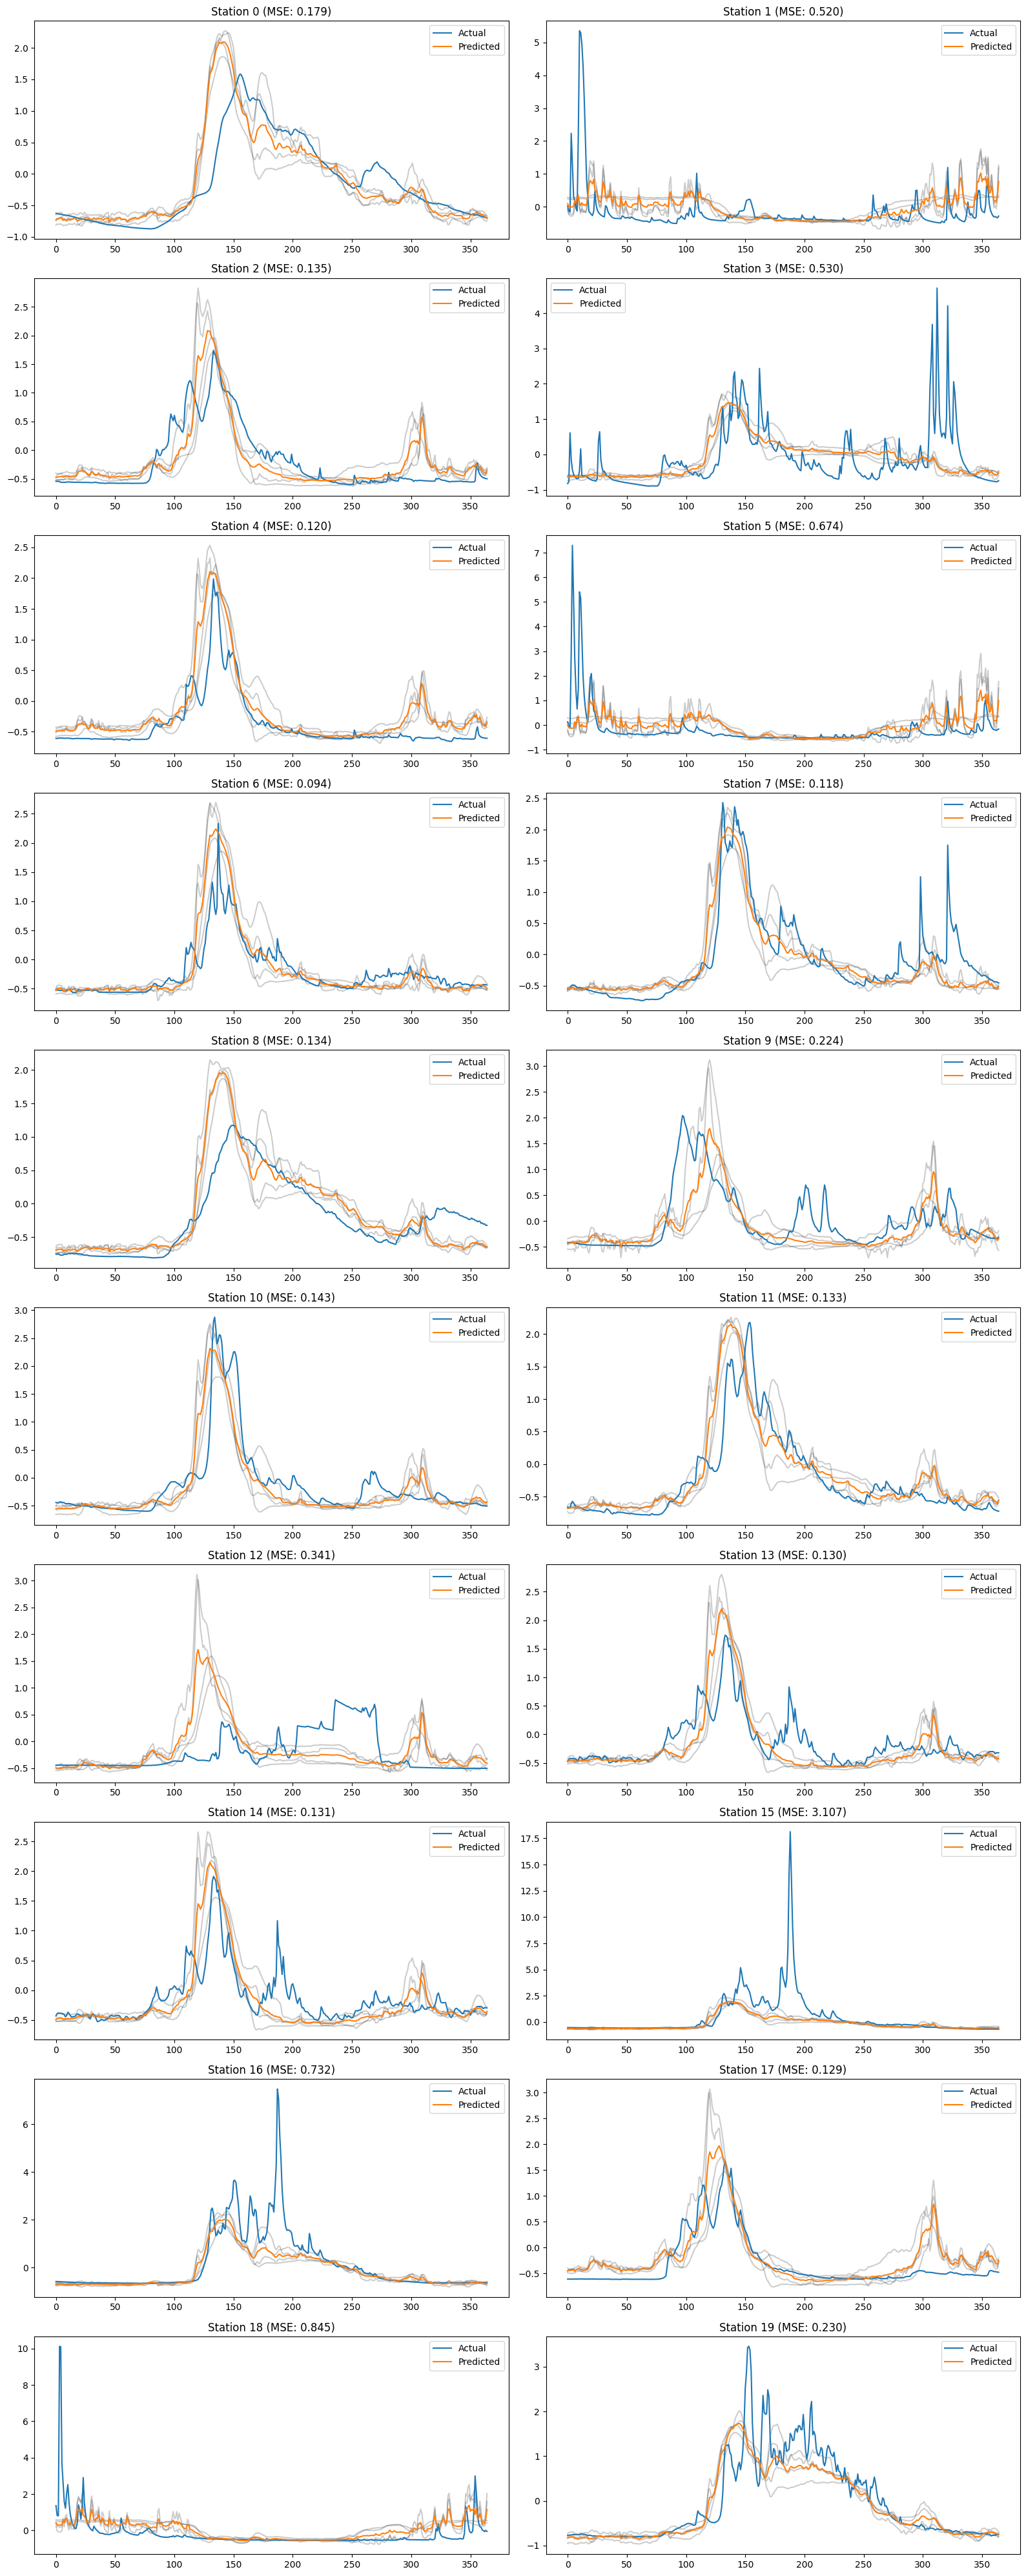

In [54]:
# plot the model predictions for the first 20 stations using subplots
n_plot = 20

predictions = ensemble_mean

fig, axs = plt.subplots(n_plot // 2, 2, figsize=(16, n_plot * 2))
for i in range(n_plot):
    mse = np.mean((val_data[:, i] - predictions[:, i]) ** 2)
    station = i
    ax = axs[i // 2, i % 2]
    ax.plot(np.array(ensemble_predictions).T[i], c='k', alpha=0.2)
    ax.plot(val_data[:, station], label='Actual')
    ax.plot(predictions[:, station], label='Predicted')
    ax.set_title(f"Station {station} (MSE: {mse:.3f})")
    ax.legend()
plt.tight_layout()
plt.show()